In [1]:
import os
import random
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
import numpy as np
import time
import math
from model.basic import DispNetSimple
import cv2
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda:1")

In [3]:
class WrappedModel(nn.Module):
    def __init__(self):
        super(WrappedModel, self).__init__()
        self.module = DispNetSimple().to(device) # that I actually define.
    def forward(self, x):
        return self.module(x)

In [4]:
def test(model, imgL, imgR):
        model.eval()

        imgL = torch.FloatTensor(imgL).to(device)
        imgR = torch.FloatTensor(imgR).to(device)   

        with torch.no_grad():
            input_cat = torch.cat((imgL, imgR), 1)
            #print(input_cat.shape)
            disp = model(input_cat)
            disp = torch.squeeze(disp)

        pred_disp = disp.data.cpu().numpy()
        print(pred_disp.shape)
        print('min: %f, max: %f, mean: %f' % (np.min(pred_disp), np.max(pred_disp), np.mean(pred_disp)))

        return pred_disp

In [5]:
data_transforms = transforms.Compose([
            transforms.ToTensor()
        ])

In [6]:
def generate_output(epoch, img_path):

    print("Loading model")
    # then I load the weights I save from previous code:
    model = WrappedModel()
    state_dict = torch.load("saved_models/kitti_" + epoch + "_dispnet.pth")
    model.load_state_dict(state_dict)

    print("Model loaded")

    left_img = "data_scene_flow/testing/image_2/" + img_path + ".png"
    right_img = "data_scene_flow/testing/image_2/" + img_path + ".png"
    
    th, tw = 512, 1344
    imgL_o = Image.open(left_img).convert('RGB').resize((tw, th))
    imgR_o = Image.open(right_img).convert('RGB').resize((tw, th))

    imgL = data_transforms(imgL_o).unsqueeze(0)
    imgR = data_transforms(imgR_o).unsqueeze(0)
    print(imgL.shape)

    start_time = time.time()
    pred_disp = test(model, imgL,imgR)
    print('time = %.2f' %(time.time() - start_time))


    img = (pred_disp*256).astype('uint16')
    img = Image.fromarray(img)

    f = plt.figure()
    f.add_subplot(2,1,1)
    plt.imshow(np.asarray(imgL_o))
    f.add_subplot(2,1,2)
    plt.imshow(np.asarray(img.resize((tw, th))))
    figmn = plt.get_current_fig_manager()
    figmn.full_screen_toggle()
    plt.show()
    print('total time = %.2f' %(time.time() - start_time))
    img.save("output_images/" + img_path + ".png")

Loading model
Model loaded
torch.Size([1, 3, 512, 1344])
(512, 1344)
min: -3.494120, max: 2.022462, mean: 0.137121
time = 0.17


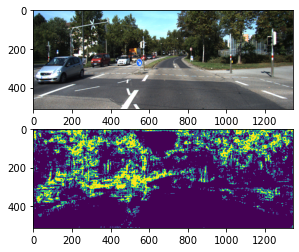

total time = 0.60


In [9]:
generate_output("140", "000010_11")